## SRPT vs. BASRPT vs. Random

In [1]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import pickle

DATA_NAME = 'university_chancap500_numchans1_mldat2e6_bidirectional'
# DATA_NAME = 'ndf50_mldat6e6_load0.4_university'
path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/{}_testbed_data_v30.obj'.format(DATA_NAME)
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [2]:
%autoreload
# unpack env dicts into list of env objects
envs = tb_dict['envs']



-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_university_load_0.2_repeat_0_scheduler_srpt'
Measurement duration: 1823583.2959999975 (Start time : 227947.9119999997 | End time: 2051531.2079999973)
Total number of generated demands (jobs or flows) passed to env: 52800
Total number of these demands which arrived during measurement period: 42239
Total info arrived: 1099894370.0 info unit demands arrived
Total info transported: 1099894370.0 info unit demands transported
Load (abs): 1206.3001151771919 info unit demands arrived per unit time (from first to last flow arriving)
Load (frac): 0.20105001919619864 fraction of network capacity requested (from first to last flow arriving)
Throughput (abs): 603.1500575885959 info units transported per unit time
Throughput (frac): 1.0 fraction of arrived info successfully transported

 ~* Flow Information *~
Total number of generated flows passed to env (src != dst, dependency_type == 'data_dep'): 528

/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:273: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:273: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:273: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicit

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:312: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig =

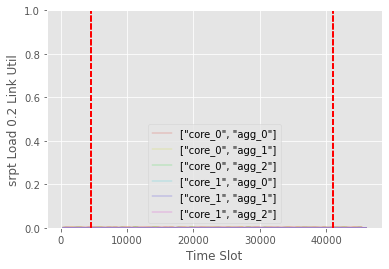

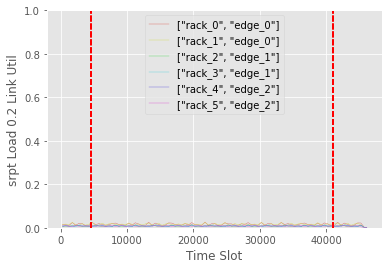

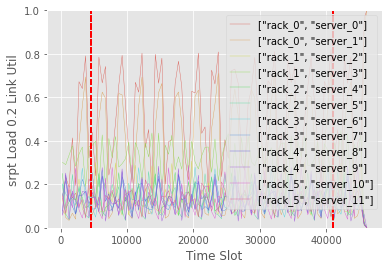

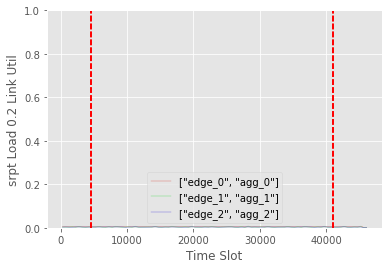

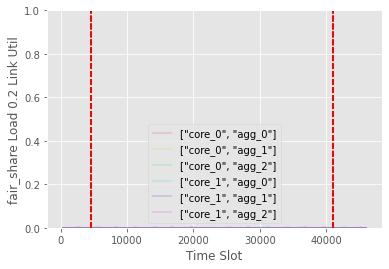

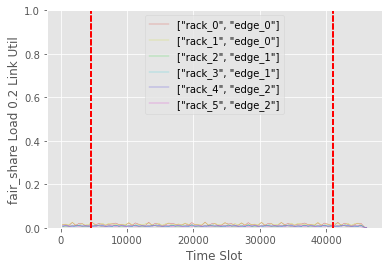

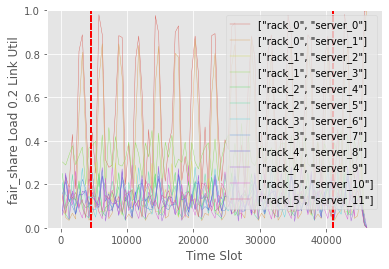

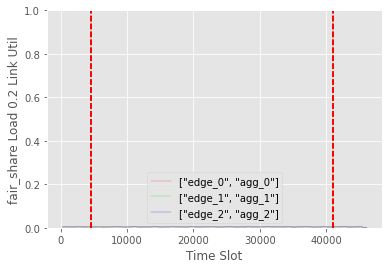

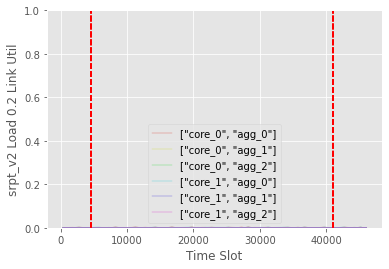

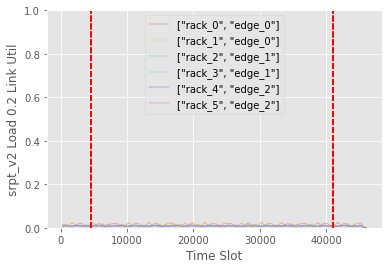

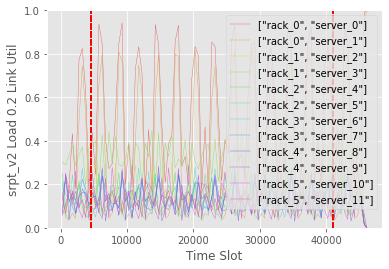

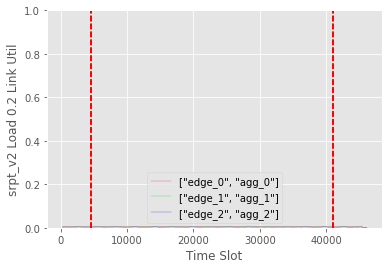

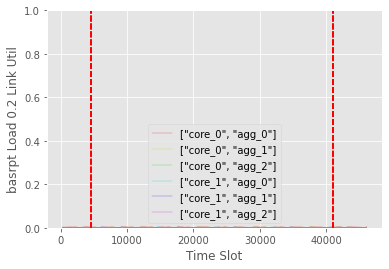

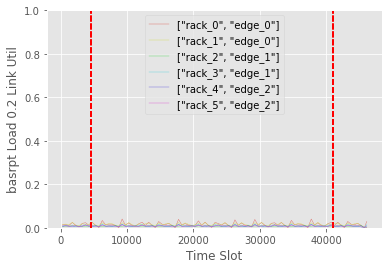

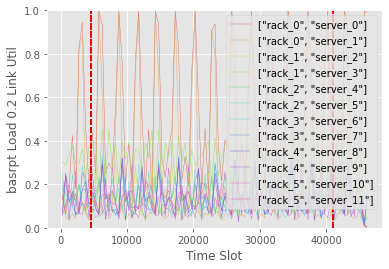

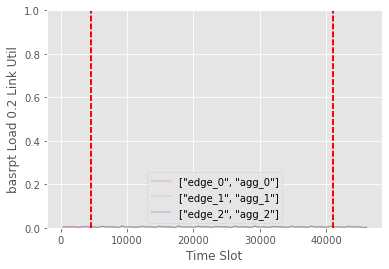

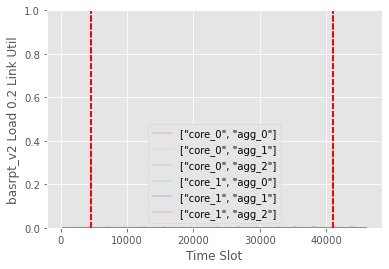

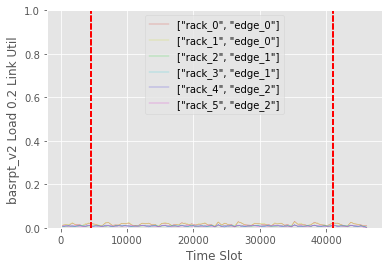

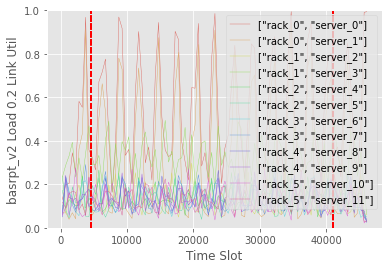

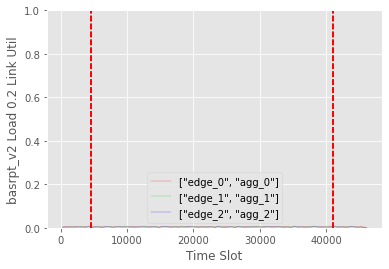

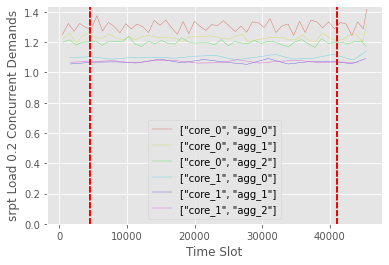

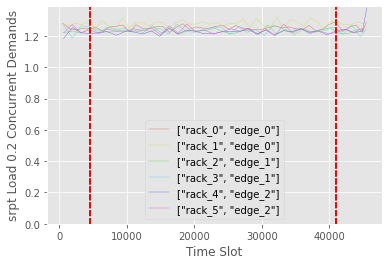

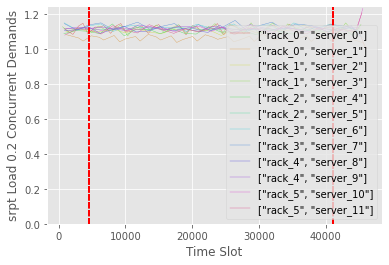

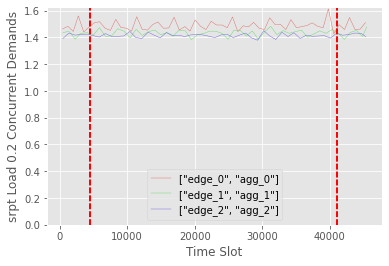

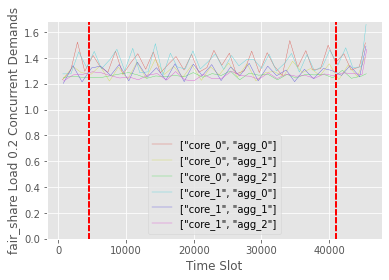

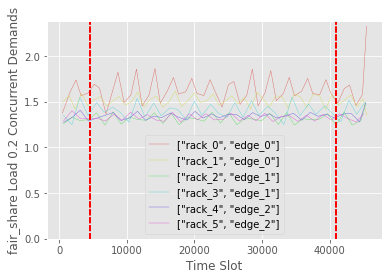

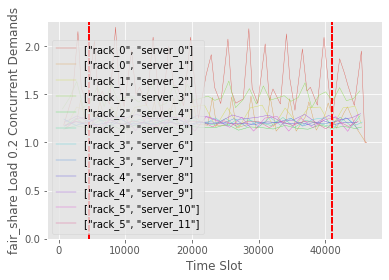

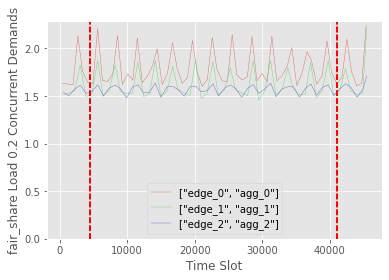

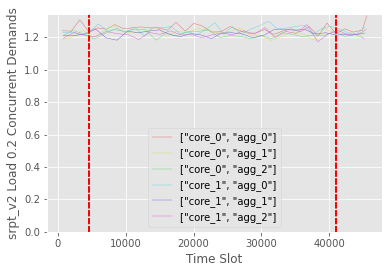

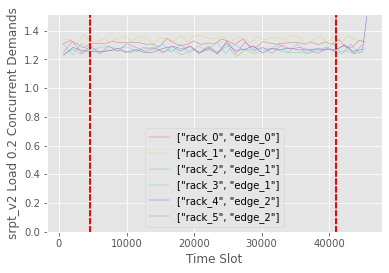

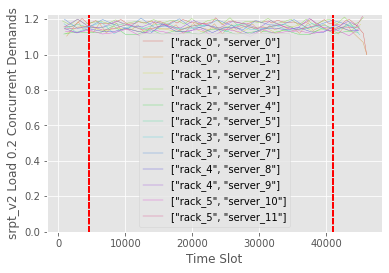

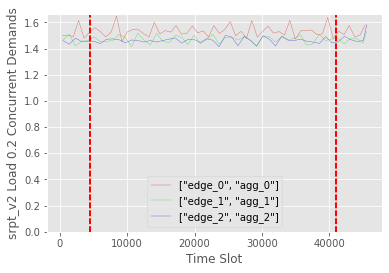

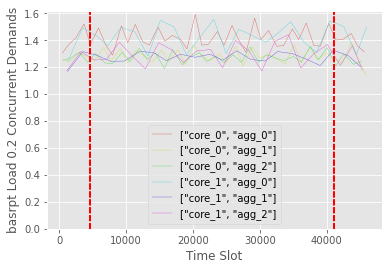

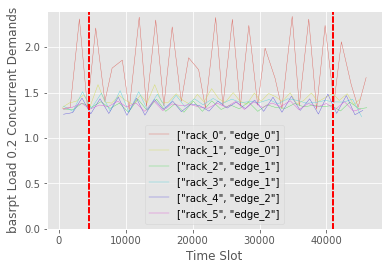

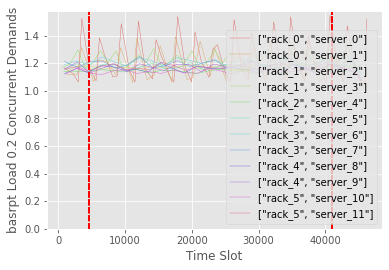

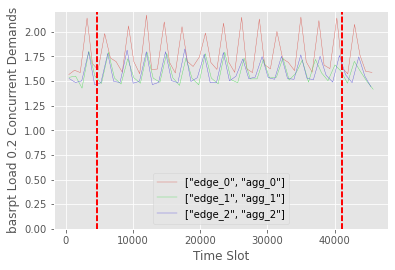

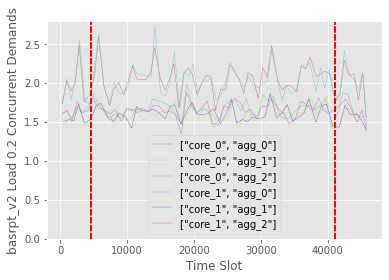

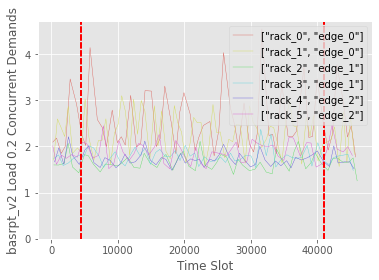

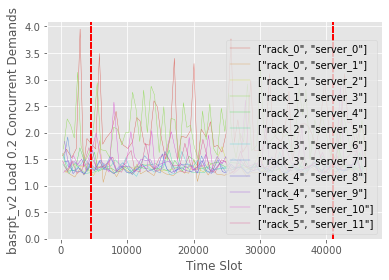

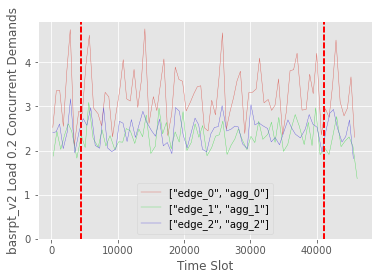

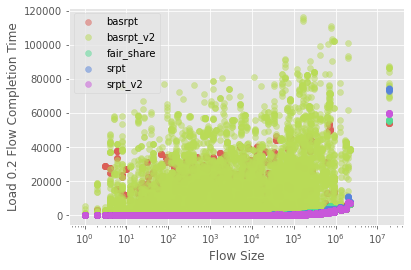

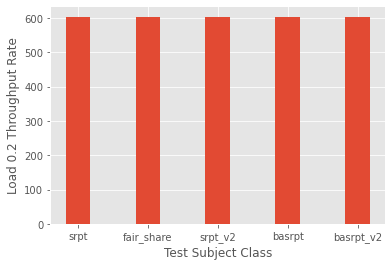

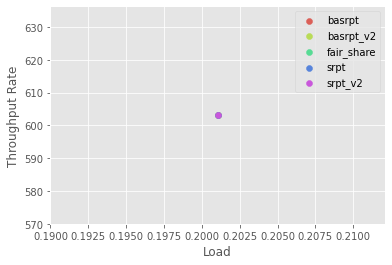

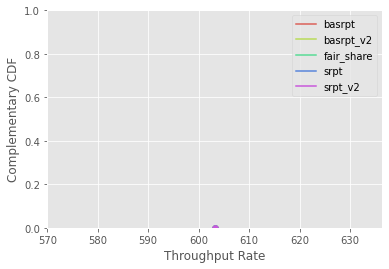

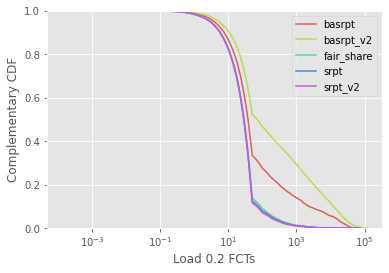

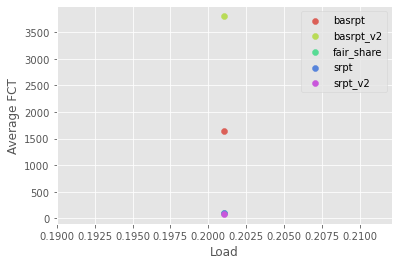

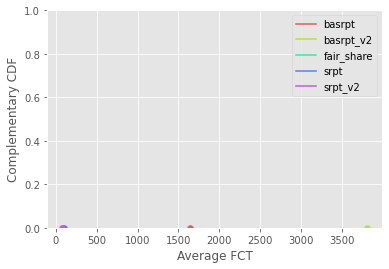

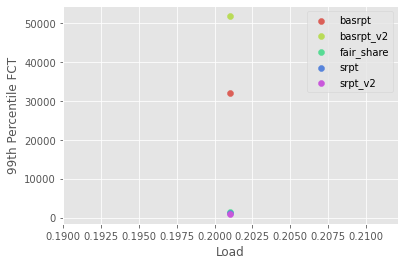

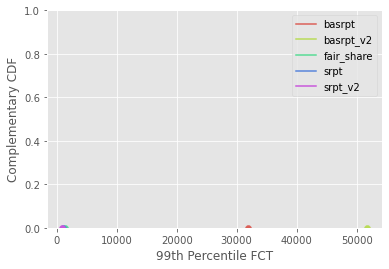

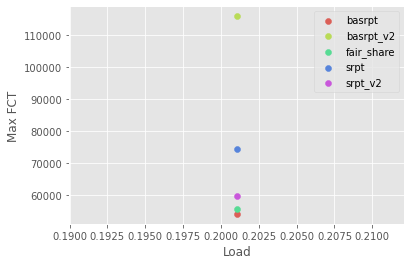

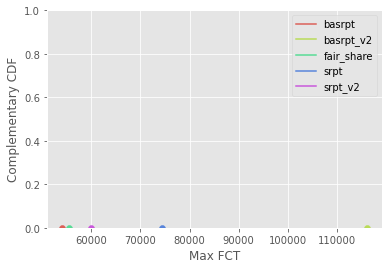

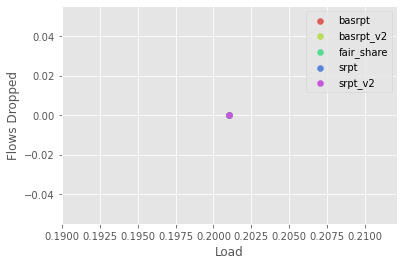

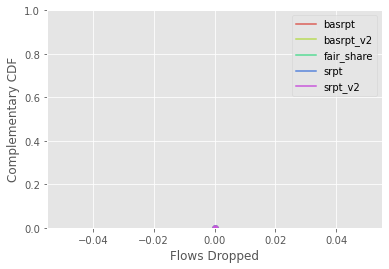

In [3]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

# analyse
analysers = [EnvAnalyser(env, env.scheduler.scheduler_name) for env in envs]
for analyser in analysers:
    analyser.compute_metrics(measurement_start_time='auto',
                             measurement_end_time='auto',
                             print_summary=True)
# plot
plotter = EnvsPlotter()
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_num_flows', *analysers)
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_info_units', *analysers)
# _ = plotter.plot_demand_slot_colour_grid_for_different_schedulers(*analysers)
_ = plotter.plot_link_utilisation_vs_time_for_different_loads(*analysers, mean_period=500)
_ = plotter.plot_link_concurrent_demands_vs_time_for_different_loads(*analysers, mean_period=500)
_ = plotter.plot_demand_completion_time_vs_size_for_different_loads(*analysers)
_ = plotter.plot_throughput_vs_load(*analysers)
_ = plotter.plot_fcts_cdf_for_different_loads(*analysers)
_ = plotter.plot_average_fct_vs_load(*analysers)
_ = plotter.plot_99th_percentile_fct_vs_load(*analysers)
_ = plotter.plot_max_fct_vs_load(*analysers)
_ = plotter.plot_fraction_of_arrived_flows_dropped_vs_load(*analysers)

In [ ]:
# %autoreload
# import trafpy
# import trafpy.generator as tpg
# from trafpy.manager import RandomAgent, RWA, Demand, DCN, EnvAnalyser
# import json

# DATA_BAME = 'artificial_light_chancap10'
# path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data.json'.format(DATA_NAME)
# benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))
# benchmarks = list(benchmark_data.keys())

# SLOT_SIZE = 1.0
# PACKET_SIZE = 1
# NUM_CHANNELS = 1
# NUM_K_PATHS = 1
# MAX_FLOWS = 10
# MAX_TIME = None

In [ ]:
# network = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=10)
# rwa = RWA(tpg.gen_channel_names(NUM_CHANNELS), NUM_K_PATHS)
# scheduler = RandomAgent(network, rwa, slot_size=SLOT_SIZE, packet_size=PACKET_SIZE)

# num_benchmark_tests = 0
# for benchmark in benchmarks:
#     for load in benchmark_data[benchmark]:
#         for repeat in benchmark_data[benchmark][load]:
#             num_benchmark_tests += 1

# for benchmark in benchmarks:
#     for load in list(benchmark_data[benchmark].keys()):
#         for repeat in benchmark_data[benchmark][load]:
#             if json.loads(load) == 0.1 and scheduler.scheduler_name == 'random':
#                 demand_data = benchmark_data[benchmark][load][repeat]
#                 demand = tpg.Demand(demand_data)
#                 env = DCN(network, demand, scheduler, num_k_paths=NUM_K_PATHS, slot_size=SLOT_SIZE, max_flows=MAX_FLOWS, max_time=MAX_TIME)
#                 print(env.slot_size)
                
#                 observation = env.reset()
#                 scheduler.register_env(env)
                
#                 while True:
#                     action = scheduler.get_action(observation)
#                     observation, reward, done, info = env.step(action)
                    
#                     if done:
#                         print('Completed')
#                         analyser = EnvAnalyser(env)
#                         analyser.compute_metrics(print_summary=True)

In [ ]:
# packet size = info
# slot size = sec
# min bandwidth in network = info per sec

# assume that 1 packet size of info can be transferred per sub slot
# info per sub slot = 1 packet = packet size
# sub slot size = (info per sub slot / min bandwidth in network) * slot size

In [ ]:
a = None
if a is not None:
    print('not none')
else:
    print('None')

In [ ]:
increment_time = 1.001
print(round(1-(increment_time-1),6))